In [1]:
%matplotlib inline

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = '../../Rotated_IoU/'
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
import json
import cv2
from glob import glob
import math
import numpy as np
import time
from progress.bar import Bar
import torch

import matplotlib.pyplot as plt
from PIL import Image

from external.nms import soft_nms
from fhd_opts import opts
from logger import Logger
from utils.utils import AverageMeter
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory
from models.losses import _transpose_and_gather_feat

In [4]:
class PrefetchDataset(torch.utils.data.Dataset):
  def __init__(self, opt, dataset, pre_process_func):
    self.images = dataset.images
    self.load_image_func = dataset.coco.loadImgs
    self.img_dir = dataset.img_dir
    self.pre_process_func = pre_process_func
    self.opt = opt
  
  def __getitem__(self, index):
    img_id = self.images[index]
    img_info = self.load_image_func(ids=[img_id])[0]
    img_path = os.path.join(self.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    images, meta = {}, {}
    for scale in opt.test_scales:
      if opt.task == 'ddd':
        images[scale], meta[scale] = self.pre_process_func(
          image, scale, img_info['calib'])
      else:
        images[scale], meta[scale] = self.pre_process_func(image, scale)
    return img_id, {'images': images, 'image': image, 'meta': meta}

  def __len__(self):
    return len(self.images)

def prefetch_test(opt):
  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str

  Dataset = dataset_factory[opt.dataset]
  opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
  print(opt)
  Logger(opt)
  Detector = detector_factory[opt.task]
  
  split = 'val' if not opt.trainval else 'test'
  dataset = Dataset(opt, split)
  detector = Detector(opt)
  
  data_loader = torch.utils.data.DataLoader(
    PrefetchDataset(opt, dataset, detector.pre_process), 
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

  results = {}
  num_iters = len(dataset)
  bar = Bar('{}'.format(opt.exp_id), max=num_iters)
  time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
  avg_time_stats = {t: AverageMeter() for t in time_stats}
  for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    ret = detector.run(pre_processed_images)
    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                   ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
      avg_time_stats[t].update(ret[t])
      Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
        t, tm = avg_time_stats[t])
    bar.next()
  bar.finish()
  dataset.run_eval(results, opt.save_dir)

In [19]:
args = ['eldet']
opt = opts().parse(args)
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/0203_eldet_fhd_dla_iou_newest/model_best.pth'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.resume = True
opt.gpus_str = '5'

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = dataset_factory[opt.dataset]
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'reg': 2, 'l': 1, 'ratio_al': 1, 'ratio_ba': 1, 'theta': 1}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, ellipse_reg_weight=0, ellipse_weight=1, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, flip=0.5, flip_test=False, gpus=[

In [20]:
Detector = detector_factory[opt.task]

In [21]:
split = 'val'
# split = 'train'
opt.mean = [0, 0, 0]
opt.std = [1, 1, 1]
dataset = Dataset(opt, split)
detector = Detector(opt)

model = detector.model

==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded val 232 samples
Creating model...
loaded /data/cc/workspace/Repository/CenterNet/exp/eldet/0203_eldet_fhd_dla_iou_newest/model_best.pth, epoch 550


In [22]:
ind = 0
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
print(img_path)

image = cv2.imread(img_path)

/data/cc/Data/CHD/detection/images/normal_0001.png


In [9]:
ret = detector.run(img_path)
ret

/home/cc/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


{'results': {1: array([[ 2.5614355e+02, -9.1447239e+00,  7.8148132e+02,  5.1619299e+02,
           5.1881244e+02,  2.5352412e+02,  5.2533771e+02,  2.6554450e-01,
           7.9678476e-01, -8.2494337e-03,  7.5431490e-01]], dtype=float32),
  2: array([[ 4.4332541e+02,  9.5700249e+01,  7.3027576e+02,  3.8265067e+02,
           5.8680060e+02,  2.3917546e+02,  2.8695041e+02,  5.8908790e-01,
           7.1021610e-01, -2.6900655e-02,  8.1878120e-01]], dtype=float32)},
 'tot': 7.353118658065796,
 'load': 0.0440065860748291,
 'pre': 0.14002132415771484,
 'net': 6.86904501914978,
 'dec': 0.2560391426086426,
 'post': 0.04000592231750488,
 'merge': 0.004000663757324219}

# With Ground Truth

In [11]:
ann = anns[class_idx]
cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
ratio_al, ratio_ba = a_gt / l_gt, b_gt / a_gt
angle_gt = theta_gt * 180
print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l, ratio_al, ratio_ba, theta_gt, a_gt, b_gt, int(angle_gt))

NameError: name 'anns' is not defined

In [10]:
thetas = []
for ind in range(len(dataset)):
    img_id = dataset.images[ind]
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)
    for ann in anns:
        angle = ann['ellipse'][-1] / math.pi
        angle = angle - 1 if angle > 0.5 else angle + 1 if angle < -0.5 else angle
        thetas.append(angle)
        print(ann['ellipse'][-1] / math.pi, angle)

-0.9546113486651883 0.045388651334811736
0.9507916300309828 -0.04920836996901723
0.8600733124686024 -0.1399266875313976
-0.9842141680802808 0.015785831919719162
-0.9195972611849712 0.0804027388150288
-0.7295662591332482 0.27043374086675176
-0.8537071147449266 0.14629288525507345
0.11745634800181876 0.11745634800181876
0.9845324779664646 -0.015467522033535408
-0.9832592384217295 0.016740761578270535
0.9027268372172303 -0.09727316278276965
-0.8295155633949585 0.17048443660504153
-0.9803944494460753 0.019605550553924656
0.9036817668757817 -0.09631823312421828
0.14833240696164646 0.14833240696164646
0.7811324606950224 -0.2188675393049776
-0.7964113352318443 0.20358866476815574
-0.03915211600060625 -0.03915211600060625
0.039788735772973836 0.039788735772973836
0.08339719018015317 0.08339719018015317
0.007639437268410976 0.007639437268410976
-0.8412930291837587 0.1587069708162413
-0.042971834634811745 -0.042971834634811745
0.016233804195373323 0.016233804195373323
-0.02355493157760051 -0.023

In [11]:
min(thetas), max(thetas)

(-0.34587318389231014, 0.4469070802020421)

In [3]:
ind += 1



# Load Image
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
image = cv2.imread(img_path)
print(img_path)

# Load annotations
ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
anns = dataset.coco.loadAnns(ids=ann_ids)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
ret = detector.run(img_path)

for class_idx in range(opt.num_classes):
    class_id = class_idx + 1
    pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
    pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
    cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
    l = int(ret['results'][class_id][0, 6]) # !attention here!
    ratio_al = ret['results'][class_id][0, 7]
    ratio_ba = ret['results'][class_id][0, 8]
    a = ratio_al * l
    b = ratio_ba * a
    theta = ret['results'][class_id][0, 9]
    angle = theta * 180
    print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, "({})'".format(theta), int(a), int(b), int(angle))
    
    # Annotations
    ann = anns[class_idx]
    cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
    theta_gt = theta_gt / math.pi
    theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
    l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
    pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
    pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
    ratio_al, ratio_ba = a_gt / l_gt, b_gt / a_gt
    angle_gt = theta_gt * 180
    print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_ba, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
    img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
#     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
#     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)
    
    
    pt1 = (int(cx - l / 2), int(cy - l / 2))
    pt2 = (int(cx + l / 2), int(cy + l / 2))
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
    img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
# img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

NameError: name 'ind' is not defined

In [32]:
(cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0)

((551, 369), (232, 256), -25.186803755651567, 0.0, 360.0, (255, 0, 0))

# With Ground Truth

/data/cc/Data/CHD/detection/images/abnormal_0058.png
(-704, -678) (1132, 1158) (213, 239) 459 0.39113346 0.7888333 0.5965246 179.53025695681572 141.61944866098284 107
(-215, -254) (689, 651) (236, 198) 226 0.34028825 0.90244985 0.72942054 76.90514487028122 69.4030361653805 131


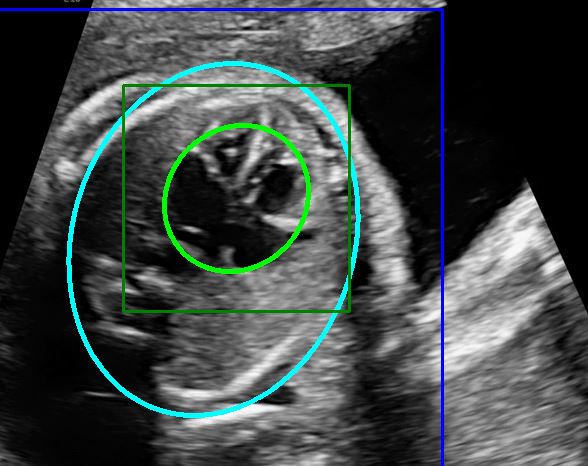

In [18]:
ind += 1



# Load Image
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
image = cv2.imread(img_path)
print(img_path)

# Load annotations
# ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
# anns = dataset.coco.loadAnns(ids=ann_ids)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
ret = detector.run(img_path)

for class_idx in range(opt.num_classes):
    class_id = class_idx + 1
    pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
    pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
    cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
    l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
    ratio_al = ret['results'][class_id][0, 7]
    ratio_ba = ret['results'][class_id][0, 8]
    a = ratio_al * l
    b = ratio_ba * a
    theta = ret['results'][class_id][0, 9]
    angle = theta * 180
    print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))
    
    pt1 = (int(cx - l / 2), int(cy - l / 2))
    pt2 = (int(cx + l / 2), int(cy + l / 2))
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
    img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
# img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

In [146]:
len(dataset.images)

100

In [147]:
for ind in range(len(dataset.images)):

    # Load Image
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    print(img_path)

    # Load annotations
    # ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    # anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    red = (255, 0, 0)
    green = (0, 255, 0)
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        class_id = class_idx + 1
        pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
        pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
        cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
        l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
        ratio_al = ret['results'][class_id][0, 7]
        ratio_ba = ret['results'][class_id][0, 8]
        a = ratio_al * l
        b = ratio_ba * a
        theta = ret['results'][class_id][0, 9]
        angle = theta * 180
        print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))

        pt1 = (int(cx - l / 2), int(cy - l / 2))
        pt2 = (int(cx + l / 2), int(cy + l / 2))
        img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
        img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

    img = Image.fromarray(image)
    img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

/data/cc/Data/CHD/detection/images/abnormal_0000.png
(-936, -1078) (1752, 1610) (408, 265) 672 0.38649797 0.8034471 0.59329367 259.7266387939453 208.67662183324683 106
(-185, -443) (1156, 898) (485, 227) 335 0.37068468 0.845624 0.7307339 124.17936891317368 105.00905833806092 131


/home/cc/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/cc/Data/CHD/detection/images/abnormal_0001.png
(-1316, -1272) (1915, 1958) (299, 342) 807 0.38554302 0.7937233 0.63559026 311.1332159936428 246.95367833275895 114
(-571, -638) (1256, 1189) (342, 275) 456 0.33497074 0.92716104 0.7286147 152.7466585636139 141.62075049294316 131
/data/cc/Data/CHD/detection/images/abnormal_0002.png
(-685, -837) (1439, 1287) (377, 224) 531 0.37524202 0.83682317 0.6011875 199.25351509451866 166.73995722180283 108
(-284, -431) (938, 790) (327, 179) 305 0.35961708 0.8853992 0.6915283 109.68321070075035 97.11342946192383 124
/data/cc/Data/CHD/detection/images/abnormal_0003.png
(-692, -752) (1530, 1470) (418, 358) 555 0.39406824 0.78408897 0.555698 218.70787382125854 171.48643134713808 100
(2, -134) (973, 836) (487, 350) 242 0.40083143 0.7550271 0.67525923 97.00120633840561 73.23854100667164 121
/data/cc/Data/CHD/detection/images/abnormal_0004.png
(-519, -769) (1604, 1353) (542, 292) 530 0.39346087 0.7875335 0.55879354 208.53426098823547 164.2277209412086 

/data/cc/Data/CHD/detection/images/abnormal_0032.png
(-806, -967) (1589, 1427) (391, 230) 598 0.38490686 0.81165266 0.5962233 230.17430120706558 186.82158392349126 107
(-206, -404) (939, 741) (366, 168) 286 0.35623533 0.889675 0.6737016 101.8833030462265 90.64302979468103 121
/data/cc/Data/CHD/detection/images/abnormal_0033.png
(-909, -1115) (2023, 1817) (557, 350) 733 0.39270958 0.7791342 0.5783564 287.8561243712902 224.27855518535182 104
(-323, -462) (1273, 1134) (475, 335) 399 0.39549834 0.7689658 0.67642796 157.8038358092308 121.34574980602542 121
/data/cc/Data/CHD/detection/images/abnormal_0034.png
(-1166, -1531) (2495, 2130) (664, 299) 915 0.39691207 0.759723 0.5908772 363.174542337656 275.9120556172031 106
(-466, -761) (1548, 1253) (540, 246) 503 0.38555905 0.8128723 0.67110515 193.9362032711506 157.64536578547248 120
/data/cc/Data/CHD/detection/images/abnormal_0035.png
(-847, -983) (1615, 1480) (383, 248) 615 0.3936838 0.7713871 0.5814489 242.11553156375885 186.76479781112562 1

/data/cc/Data/CHD/detection/images/normal_0011.png
(-719, -946) (1796, 1569) (538, 311) 629 0.38840213 0.8016191 0.56186837 244.30494239926338 195.83951110341084 101
(-210, -377) (1151, 984) (470, 303) 340 0.4012519 0.76307815 0.67414427 136.4256501197815 104.10343313342523 121
/data/cc/Data/CHD/detection/images/normal_0012.png
(-1047, -1337) (2353, 2063) (653, 362) 850 0.3799395 0.82476175 0.58279085 322.9485720396042 266.35562889086265 104
(-284, -566) (1415, 1133) (565, 283) 424 0.35486376 0.8842327 0.67831975 150.46223545074463 133.04362868124753 122
/data/cc/Data/CHD/detection/images/normal_0013.png
(-1328, -1566) (2431, 2192) (551, 313) 939 0.38674694 0.7987437 0.6216092 363.15537947416306 290.0680804907023 111
(-521, -632) (1519, 1408) (498, 388) 510 0.38006058 0.8119076 0.67992705 193.83089751005173 157.37277675552056 122
/data/cc/Data/CHD/detection/images/normal_0014.png
(-656, -762) (1483, 1378) (413, 307) 535 0.3723557 0.8542538 0.5708149 199.21029925346375 170.1761608189905

/data/cc/Data/CHD/detection/images/normal_0041.png
(-848, -933) (1656, 1571) (404, 318) 626 0.38553208 0.80070436 0.5949264 241.34308278560638 193.24445864426457 107
(-246, -325) (957, 878) (355, 276) 300 0.38648233 0.8026103 0.67156076 115.94469845294952 93.05840667297183 120
/data/cc/Data/CHD/detection/images/normal_0042.png
(-868, -1035) (1905, 1738) (518, 351) 693 0.38248134 0.8247764 0.6210107 265.05956625938416 218.61487777561234 111
(-188, -292) (1073, 970) (442, 339) 315 0.3993388 0.7493425 0.67513514 125.79172566533089 94.2610863357297 121
/data/cc/Data/CHD/detection/images/normal_0043.png
(-548, -723) (1527, 1352) (489, 314) 519 0.3818812 0.83510983 0.56738937 198.1963465511799 165.5157172556823 102
(-193, -316) (1142, 1019) (474, 351) 334 0.38090873 0.84981287 0.58829707 127.22351503372192 108.11617983890773 105
/data/cc/Data/CHD/detection/images/normal_0044.png
(-990, -1014) (1564, 1540) (286, 262) 638 0.40253827 0.749724 0.6030265 256.8194161057472 192.54367244446362 108
(

In [145]:
img = Image.fromarray(image)
img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

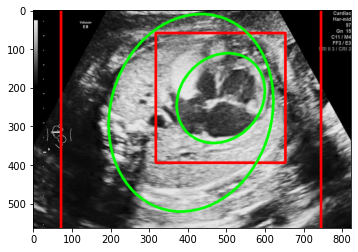

In [37]:
# image = np.array(Image.open(img_path).convert('RGB'))
lung_pt1 = (int(cx - l / 2), int(cy - l / 2))
lung_pt2 = (int(cx + l / 2), int(cy + l / 2))
img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (0, 255, 0), thickness=5)
# img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
plt.imshow(image)

In [14]:
preprocessed_image, meta = detector.pre_process(image, scale=1.0)
preprocessed_image = preprocessed_image.to(opt.device)
preprocessed_image.shape

torch.Size([1, 3, 512, 512])

In [15]:
output = model(preprocessed_image)[-1]

In [ ]:
print(output['hm'].shape, output['reg'].shape, output['l'].shape, output['ratio_al'].shape, output['ratio_ba'].shape, output['theta'].shape)

In [ ]:
from models.decode import _nms, _left_aggregate, _right_aggregate, _top_aggregate, \
                        _bottom_aggregate, _h_aggregate, _v_aggregate, _topk_channel, \
                        _topk
from models.utils import _gather_feat, _transpose_and_gather_feat

In [ ]:
def test_eldet_decode(heat, l, ratio_al, ratio_ba, theta, reg=None, cat_spec_wh=False, K=2): # Decode ellipse information
    batch, cat, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _transpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
    l = _transpose_and_gather_feat(l, inds)
    ratio_al = _transpose_and_gather_feat(ratio_al, inds)
    ratio_ba = _transpose_and_gather_feat(ratio_ba, inds)
    theta = _transpose_and_gather_feat(theta, inds)
    if cat_spec_wh:
      l = l.view(batch, K, cat, 1)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      l = l.gather(1, clses_ind).view(batch, K, 1)
    else:
      l = l.view(batch, K, 1)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - l / 2, 
                        ys - l / 2,
                        xs + l / 2, 
                        ys + l / 2], dim=2)
#     print(bboxes.shape, scores.shape, clses.shape, xs.shape, ys.shape, l.shape, ratio_al.shape, ratio_ba.shape, theta.shape)
#     print('bboxes:', bboxes, 'scores:', scores, 'clses:', clses, 'xs:', xs, 'ys:', ys, 'l:', l, 'ratio_al:', ratio_al, 'ratio_ba:', ratio_ba, 'theta:', theta)
    detections = torch.cat([bboxes, scores, clses, xs, ys, l, ratio_al, ratio_ba, theta], dim=2) # batch x max_dets x dim
      
    return detections

In [ ]:
def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords

def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


In [ ]:
# output -> detection
hm = output['hm'].sigmoid_()
l = output['l']
ratio_al = output["ratio_al"]
ratio_ba = output["ratio_ba"]
theta = output["theta"]
reg = output['reg'] if opt.reg_offset else None

dets = test_eldet_decode(hm, l, ratio_al, ratio_ba, theta, reg=reg)
dets

In [ ]:
[meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

In [ ]:
ret = []
i = 0
num_classes = 2
top_preds = {}
c, s, h, w, num_classes = [meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

print("Origin:", dets)
dets[i, :, :2] = transform_preds(
      dets[i, :, 0:2], c[i], s[i], (w, h))
dets[i, :, 2:4] = transform_preds(
      dets[i, :, 2:4], c[i], s[i], (w, h))
print("Transformed:", dets)
classes = dets[i, :, -1]
for j in range(num_classes):
  inds = (classes == j)
  top_preds[j + 1] = np.concatenate([
    dets[i, inds, :4].astype(np.float32),
    dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
ret.append(top_preds)

In [ ]:
classes

In [ ]:
# eldet post processing
def eldet_post_process(dets, c, s, h, w, num_classes):
  # dets: batch x max_dets x dim
  # return 1-based class det dict
  ret = []
  for i in range(dets.shape[0]):
    top_preds = {}
    dets[i, :, :2] = transform_preds(
          dets[i, :, 0:2], c[i], s[i], (w, h))
    dets[i, :, 2:4] = transform_preds(
          dets[i, :, 2:4], c[i], s[i], (w, h))
    classes = dets[i, :, -1]
    for j in range(num_classes):
      inds = (classes == j)
      top_preds[j + 1] = np.concatenate([
        dets[i, inds, :4].astype(np.float32),
        dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
    ret.append(top_preds)
  return ret

In [ ]:
dets = dets.detach().cpu().numpy()
dets = dets.reshape(1, -1, dets.shape[2])
dets = eldet_post_process(
    dets.copy(), [meta['c']], [meta['s']],
    meta['out_height'], meta['out_width'], self.opt.num_classes)
for j in range(1, self.num_classes + 1):
  dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
  dets[0][j][:, :4] /= scale

In [ ]:
def post_process(self, dets, meta, scale=1):
    dets = dets.detach().cpu().numpy()
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = eldet_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], self.opt.num_classes)
    for j in range(1, self.num_classes + 1):
      dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
      dets[0][j][:, :4] /= scale
    return dets[0]

In [ ]:
batch, cat, height, width = hm.size()
heat = _nms(hm)
scores, inds, clses, ys, xs = _topk(heat, K=2)
scores, inds, clses, ys, xs

In [ ]:
reg.shape, inds

In [ ]:
K = 2
cat_spec_wh = False
if reg is not None:
  reg = _transpose_and_gather_feat(reg, inds)
  reg = reg.view(batch, K, 2)
  xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
  ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
else:
  xs = xs.view(batch, K, 1) + 0.5
  ys = ys.view(batch, K, 1) + 0.5
l = _transpose_and_gather_feat(l, inds)
if cat_spec_wh:
  l = l.view(batch, K, cat, 1)
  clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
  l = l.gather(1, clses_ind).view(batch, K, 1)
else:
  l = l.view(batch, K, 1)
clses  = clses.view(batch, K, 1).float()
scores = scores.view(batch, K, 1)

In [ ]:
results = {}
num_iters = len(dataset)
bar = Bar('{}'.format(opt.exp_id), max=num_iters)
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
avg_time_stats = {t: AverageMeter() for t in time_stats}
for ind in range(num_iters):
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])

    if opt.task == 'ddd':
        ret = detector.run(img_path, img_info['calib'])
    else:
        ret = detector.run(img_path)

    results[img_id] = ret['results']

    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
        avg_time_stats[t].update(ret[t])
        Bar.suffix = Bar.suffix + '|{} {:.3f} '.format(t, avg_time_stats[t].avg)
    bar.next()
bar.finish()
dataset.run_eval(results, opt.save_dir)

In [ ]:
results

In [ ]:
print(img_id)
img_info = dataset.coco.loadImgs(ids=[img_id])[0]

# Inference

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
test_image_folder = '/data/cc/Data/CHD/detection/images/'
image_lists = sorted(glob(os.path.join(test_image_folder, "*.png")))
save_folder = '/data/cc/Data/CHD/detection/predictions/'

In [ ]:
idx = 0
for img_path in image_lists:
    
    idx += 1
    
    img_name = img_path.split('/')[-1]
    ret = detector.run(img_path)
    
    lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
    lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
    heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
    heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))
    
    image = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
    img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
    result = Image.fromarray(img)
    result.save(os.path.join(save_folder, img_name))
    
    print("Processing img: {}, shape:{}, Lung pt1:{} pt2:{}, Heart pt1:{}, pt2:{}".format(img_name, image.shape, lung_pt1, lung_pt2, heart_pt1, heart_pt2))
    
#     if idx > 1:
#         break


In [ ]:
ret

In [ ]:
lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))

In [ ]:
img = np.array(Image.open(img_path).convert('RGB'))
plt.imshow(img)

In [ ]:
img_path

In [ ]:
l = img[:]
l = cv2.rectangle(img=l, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
l = cv2.rectangle(img=l, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
plt.imshow(l)

In [ ]:
result = Image.fromarray(l)
result.save(os.path.join(save_folder, img_name))

# Rotated IoU

In [18]:
import math
from torch import nn, optim
import argparse
from utiles import box2corners
from oriented_iou_loss import cal_diou, cal_giou

In [16]:
output

{'hm': tensor([[[[-4.3433, -5.5296, -5.5170,  ..., -5.3087, -5.2807, -4.2913],
           [-5.4693, -7.2061, -7.2195,  ..., -6.9011, -6.8778, -5.3490],
           [-5.4691, -7.1824, -7.1806,  ..., -6.9330, -6.8808, -5.4019],
           ...,
           [-5.2143, -6.8130, -6.8661,  ..., -7.1894, -7.0903, -5.5019],
           [-5.3262, -6.8891, -6.8383,  ..., -7.1273, -7.0633, -5.4696],
           [-4.3603, -5.3907, -5.3109,  ..., -5.4597, -5.4542, -4.3752]],
 
          [[-4.4292, -5.5015, -5.5068,  ..., -5.3757, -5.3183, -4.2863],
           [-5.4769, -7.0954, -7.1240,  ..., -6.9488, -6.8777, -5.3009],
           [-5.4566, -7.0729, -7.0850,  ..., -6.9706, -6.9265, -5.3418],
           ...,
           [-5.1941, -6.6772, -6.7317,  ..., -7.1623, -7.0690, -5.4433],
           [-5.2653, -6.7094, -6.6905,  ..., -7.0680, -7.0011, -5.3971],
           [-4.2260, -5.1407, -5.1102,  ..., -5.3456, -5.3033, -4.3035]]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 'reg': tensor([[[[0.5947, 0.8

In [42]:
bbox1 = torch.tensor([[[125, 125, 100, 50, math.pi]]]).cuda()
bbox2 = torch.tensor([[[125, 125, 100, 50, 0.0 * math.pi]]]).cuda()
print(bbox1.shape, bbox2.shape)
print(bbox1, bbox2)
iou_loss, iou = cal_diou(bbox1, bbox2)
iou_loss, iou

torch.Size([1, 1, 5]) torch.Size([1, 1, 5])
tensor([[[125.0000, 125.0000, 100.0000,  50.0000,   3.1416]]], device='cuda:0') tensor([[[125., 125., 100.,  50.,   0.]]], device='cuda:0')


(tensor([[0.]], device='cuda:0'), tensor([[1.]], device='cuda:0'))